- 파일제출 : LightGBM K-Fold

---
# Setting
---

In [1]:
# !pip install datatable
# !pip install pytimekr

In [38]:
# d MyPython/2_Dacon_JEJU/DAT/
# unzip open.zip

In [39]:
import matplotlib as mpl
import matplotlib.font_manager as fm

fe = fm.FontEntry(fname='../NanumFont/NanumGothic.ttf',name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)  # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'

In [40]:
import os
import sys
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

import numpy as np
from tqdm import tqdm, trange
tqdm.pandas()

import warnings
warnings.filterwarnings(action='ignore')
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

import itertools
import datetime
from pytimekr import pytimekr
import matplotlib.pyplot as plt
import seaborn as sns

import multiprocessing as mp
from joblib import Parallel, delayed

import datatable as dt

In [5]:
# https://stackoverflow.com/questions/24983493/tracking-progress-of-joblib-parallel-execution

import contextlib
import joblib
from tqdm import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [6]:
def abline(slope, intercept, color):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',color=color)
    
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error: Creating directory. ' + directory)
        
def cnt(x):
    vc = x.value_counts().sort_index()
    res = pd.DataFrame({
        'index' : vc.index,
        'freq'  : vc.values,
    })
    res['rate'] = 100 * res['freq'] / res['freq'].sum()
    return res

In [7]:
from sklearn.metrics import mean_absolute_error

# verbose=0로 만들어주는 함수
# (참조) https://stackoverflow.com/questions/11130156/suppress-stdout-stderr-print-from-python-functions
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [8]:
os.getcwd()

'/home/ec2-user/SageMaker/Temp/Dacon/5_제주도도로교통량예측/PSC'

In [9]:
DAT_PATH = "../DAT/"
start_time = datetime.datetime.now()

print(start_time)

2022-11-11 11:18:25.191766


<br>

User Functions

In [10]:
# from lib.MyModel import *

<br></br>

---
# Data Load
---

In [11]:
%%time

train_df7 = pd.read_parquet('../OUT/train_df7.parquet.gz')
test_df7  = pd.read_parquet('../OUT/test_df7.parquet.gz')

X_train   = pd.read_parquet('../OUT/X_train.parquet.gz')
X_test    = pd.read_parquet('../OUT/X_test.parquet.gz')
y_train   = pd.read_csv('../OUT/y_train.csv')

CPU times: user 22.2 s, sys: 19.6 s, total: 41.8 s
Wall time: 32.6 s


In [21]:
cat_features = train_df7\
    .drop(['id','target','base_date'],axis=1)\
    .select_dtypes(include=[object])\
    .columns.tolist()

num_features = [x for x in train_df7.drop(['id','target','base_date'],axis=1).columns 
                if x not in cat_features]

In [26]:
segment_features = 'segment'

del_features = ['day','start_node_name','end_node_name'] # 'road_name',

new_cat_features = [col for col in cat_features if col not in [segment_features]+del_features]
new_num_features = [col for col in num_features if col not in [segment_features]+del_features]

In [27]:
X_train[new_cat_features].apply(lambda x: x.nunique())

road_name                61
weight_restricted         4
road_type                 2
start_turn_restricted     2
end_turn_restricted       2
weekday                   7
weekend                   2
holiday                   2
address                   2
stnId                     2
rnQcflg                   2
wd                       17
ssQcflg                   3
clfmAbbrCd               26
base_hour_3_interval      8
dtype: int64

<br>

One-Hot Encoding

In [ ]:
# # 6분

# print('(1) data concat')
# tmp = pd.concat([
#     X_train.assign(group='train'),
#     X_test .assign(group='test'),
# ],axis=0)

# print('(2) onehot encoding')
# tmp = pd.get_dummies(tmp, columns=new_cat_features)

# print('(3) data split')
# X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
# X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

# X_train_oh.to_parquet('../OUT/X_train_oh.parquet.gz')
# X_test_oh .to_parquet('../OUT/X_test_oh.parquet.gz')

<br></br>

---
# Transformation & Scaling
---

In [28]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

<br>

Setting Methods

In [29]:
transform_method = ['identity','log','sqrt'][0]
offset = 1e-4
scaling_method = MinMaxScaler

print(f'(1) Transformation method : {transform_method}(offset={offset})')
print(f'(2) Scaling method : {scaling_method.__name__}')

(1) Transformation method : identity(offset=0.0001)
(2) Scaling method : MinMaxScaler


<br></br>

---
# Modeling
---

In [30]:
def identity(x):
    return x

def transformation(x,offset=1e-4,method=['log','sqrt','identity']):
    #x = pd.Series(x)
    
    if method=='log':
        res = np.log(x+offset)
    elif method=='sqrt':
        res = np.sqrt(x+offset)
    elif method=='identity':
        res = identity(x)
    else:
        raise('Unknown Transformation Method')
    
    return res

def inverse_transformation(x,offset,method=['log','sqrt','identity']):
    #x = pd.Series(x)
    
    if method=='log':
        res = np.exp(x)-offset
    elif method=='sqrt':
        res = (x**2)-offset
    elif method=='identity':
        res = identity(x)
    else:
        raise('Unknown Transformation Method')
        
    return res

<br>

## AutoML

In [18]:
# !pip install pycaret

In [17]:
# !conda install -c conda-forge cudf 

from pycaret.regression import *

In [ ]:
# AUTOML_COMP_PLOT(automl)

In [ ]:
%%time

print('(1) data concat')
tmp = pd.concat([
    X_train.assign(group='train'),
    X_test .assign(group='test'),
],axis=0)

print('(2) get dummies')
tmp = pd.get_dummies(tmp, columns=new_cat_features)

print('(3) data split')
X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

In [ ]:
# train에만 있는 segment length, test에만 있는 segment length 확인
tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features] .value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

len(list(set(tr_segment)-set(te_segment))),len(list(set(te_segment)-set(tr_segment)))

In [ ]:
%%time

from sklearn.linear_model import LinearRegression
import pickle

tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1

    X_tr = X_train_oh[X_train_oh[segment_features]==segment_x]
    X_te = X_test_oh[X_test_oh[segment_features]==segment_x]
    
    y_tr = y_train[X_train_oh[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler

        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train_oh.shape[0]:,}({X_tr.shape[0]/X_train_oh.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    model = LinearRegression()
    model.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save (https://stackoverflow.com/questions/64320741/linearregression-object-has-no-attribute-save)
    models.append(model)
    # pickle.dump(model, open(f'../MDL/{now_date}/lr_{segment_x}.sav', 'wb'))

    X_tr['pred'] = model.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = model.predict(X_te.drop([segment_features,'id'],axis=1))

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df5['pred_lr'] = train_fn['pred']
test_df5 ['pred_lr'] = test_fn ['pred']

<br>

## LightGBM - 단일모델

In [69]:
# # 참조 : https://github.com/microsoft/LightGBM/issues/4843
# brew install cmake
# brew install libomp
# git clone --recursive https://github.com/microsoft/LightGBM
# cd LightGBM
# mkdir build
# cd build
# cmake ..
# make -j4

In [ ]:
%%time

import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_iterations': 5000,
    'learning_rate': 0.01,
    'metric': 'MAE',
    'verbose': -1,
    'random_state': 0,
    #'device':'gpu',
}

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features] .value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]
    
    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)

    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    
    X_tr[new_cat_features] = X_tr[new_cat_features].astype('category')
    X_te[new_cat_features] = X_te[new_cat_features].astype('category')
    
    # iterations default=1,000
    model = lgb.LGBMRegressor(**params)
    model.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save
    models.append(model)
    # model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = model.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = model.predict(X_te.drop([segment_features,'id'],axis=1))
    
    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)
    
    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

2022-11-11 12:47:19


50_106_0 : 88,540/4,686,836(1.89%):  56%|█████▌    | 14/25 [46:54<18:45, 102.36s/it]   

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df7['pred_lgb5000_0.01'] = train_fn['pred']
test_df7 ['pred_lgb5000_0'] = test_fn ['pred']

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp_df = pd.DataFrame(X_train.columns,columns=['feature_name'])

iter=0
for model in models:
    iter+=1
    
    feature_imp = pd.DataFrame(
        sorted(zip(X_train.columns,model.feature_importances_)), 
        columns=['feature_name','importance']
    )
    
    feature_imp[f'importance_{iter}'] = feature_imp['importance'] / feature_imp['importance'].sum()
    
    feature_imp_df = pd.merge(
        feature_imp_df,
        feature_imp[['feature_name',f'importance_{iter}']],
        how='left',
        on=['feature_name'],
    )

feature_imp_df = feature_imp_df.dropna()

imp_cols = [col for col in feature_imp_df.columns if col.find('importance_')>=0]
feature_imp_df['importance'] = feature_imp_df[imp_cols].apply(lambda x: sum(x),axis=1)
feature_imp_df['importance'] = 100 * feature_imp_df['importance'] / feature_imp_df['importance'].sum()
    
plt.figure(figsize=(20, 15))
sns.barplot(x="importance", y="feature_name", data=feature_imp_df.sort_values(by='importance', ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [ ]:
lgb_check_df = feature_imp_df[['feature_name','importance']].sort_values('importance',ascending=False)
lgb_check_df['cum_importance'] = lgb_check_df['importance'].cumsum()

cutoff = 99
print(f'cumulative import ≥ {cutoff}% : {np.where(lgb_check_df["cum_importance"]<=cutoff,1,0).sum()} / {lgb_check_df.shape[0]}')
display(lgb_check_df.head())

In [ ]:
train_df7.to_parquet('../OUT/train_fn.parquet.gz')
test_df7 .to_parquet('../OUT/test_fn.parquet.gz')

<br>

## CatBoost - 단일모델

In [52]:
# !pip install catboost

In [54]:
%%time

from catboost import CatBoostRegressor, Pool

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]
    
    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))

    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    
    train_data = Pool(
        X_tr.drop([segment_features,'id'],axis=1),
        y_tr,
        cat_features=new_cat_features
    )
    test_data  = Pool(
        X_te.drop([segment_features,'id'],axis=1),
        cat_features=new_cat_features
    )
    
    params = {
        'loss_function' : 'RMSE',
        'eval_metric' : 'MAE',
        'iterations' : 5000,
        'early_stopping_rounds' : 100,
        'verbose' : 1,
        'random_state' : 42,
        'metric_period' : 1000,
        'learning_rate' : 0.01,
    }
    
    GPU_ENABLED=True
    if GPU_ENABLED:
        params['task_type'] = 'GPU'
        params['bootstrap_type'] = "Poisson"

    # iterations default=1,000
    model = CatBoostRegressor(**params)
    model.fit(train_data)

    # save
    models.append(model)
    # model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = model.predict(train_data)
    X_te['pred'] = model.predict(test_data)
    
    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)
    
    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

2022-11-11 11:48:32


50_107_0 : 566,823/4,686,836(12.09%):   0%|          | 0/25 [00:02<?, ?it/s]

0:	learn: 9.3883602	total: 75.6ms	remaining: 6m 17s
1000:	learn: 3.8409234	total: 47.5s	remaining: 3m 9s
2000:	learn: 3.5600805	total: 1m 34s	remaining: 2m 21s
3000:	learn: 3.4552903	total: 2m 21s	remaining: 1m 34s
4000:	learn: 3.3986910	total: 3m 8s	remaining: 47s
4999:	learn: 3.3605495	total: 3m 55s	remaining: 0us


60_107_0 : 468,359/4,686,836(9.99%):   4%|▍         | 1/25 [04:06<1:37:51, 244.67s/it] 

0:	learn: 9.0216084	total: 59.3ms	remaining: 4m 56s
1000:	learn: 4.1560630	total: 39.6s	remaining: 2m 38s
2000:	learn: 3.9442172	total: 1m 19s	remaining: 1m 59s
3000:	learn: 3.8704442	total: 2m	remaining: 1m 20s
4000:	learn: 3.8306014	total: 2m 40s	remaining: 40.1s
4999:	learn: 3.8027827	total: 3m 20s	remaining: 0us


60_103_0 : 467,783/4,686,836(9.98%):   8%|▊         | 2/25 [07:35<1:25:37, 223.36s/it]

0:	learn: 10.0697663	total: 63.6ms	remaining: 5m 17s
1000:	learn: 4.0105928	total: 40.6s	remaining: 2m 42s
2000:	learn: 3.6651233	total: 1m 21s	remaining: 2m 1s
3000:	learn: 3.5364544	total: 2m 1s	remaining: 1m 20s
4000:	learn: 3.4673454	total: 2m 40s	remaining: 40.2s
4999:	learn: 3.4228796	total: 3m 20s	remaining: 0us


70_103_0 : 459,378/4,686,836(9.80%):  12%|█▏        | 3/25 [11:03<1:19:21, 216.43s/it]

0:	learn: 12.1894224	total: 60.5ms	remaining: 5m 2s
1000:	learn: 4.3484043	total: 40.6s	remaining: 2m 42s
2000:	learn: 4.0054051	total: 1m 20s	remaining: 2m
3000:	learn: 3.8563544	total: 1m 59s	remaining: 1m 19s
4000:	learn: 3.7704410	total: 2m 38s	remaining: 39.6s
4999:	learn: 3.7136840	total: 3m 16s	remaining: 0us


80_103_0 : 409,679/4,686,836(8.74%):  16%|█▌        | 4/25 [14:27<1:14:04, 211.63s/it]

0:	learn: 11.6827956	total: 61ms	remaining: 5m 4s
1000:	learn: 3.5403978	total: 34.8s	remaining: 2m 18s
2000:	learn: 3.2570976	total: 1m 9s	remaining: 1m 43s
3000:	learn: 3.1555916	total: 1m 43s	remaining: 1m 8s
4000:	learn: 3.0995359	total: 2m 17s	remaining: 34.4s
4999:	learn: 3.0588851	total: 2m 52s	remaining: 0us


70_106_0 : 354,068/4,686,836(7.55%):  20%|██        | 5/25 [17:26<1:06:38, 199.92s/it]

0:	learn: 10.9428090	total: 50.9ms	remaining: 4m 14s
1000:	learn: 4.0996475	total: 30.9s	remaining: 2m 3s
2000:	learn: 3.8455727	total: 1m 1s	remaining: 1m 32s
3000:	learn: 3.7502877	total: 1m 32s	remaining: 1m 1s
4000:	learn: 3.6984403	total: 2m 3s	remaining: 30.8s
4999:	learn: 3.6613091	total: 2m 34s	remaining: 0us


60_106_0 : 295,832/4,686,836(6.31%):  24%|██▍       | 6/25 [20:06<59:03, 186.50s/it]  

0:	learn: 8.1110182	total: 42.6ms	remaining: 3m 32s
1000:	learn: 3.1751733	total: 26.5s	remaining: 1m 45s
2000:	learn: 2.9952697	total: 52.9s	remaining: 1m 19s
3000:	learn: 2.9224378	total: 1m 19s	remaining: 52.7s
4000:	learn: 2.8823456	total: 1m 45s	remaining: 26.3s
4999:	learn: 2.8534246	total: 2m 11s	remaining: 0us


50_103_0 : 287,306/4,686,836(6.13%):  28%|██▊       | 7/25 [22:23<51:04, 170.23s/it]

0:	learn: 9.3838042	total: 39.1ms	remaining: 3m 15s
1000:	learn: 3.3771053	total: 24.2s	remaining: 1m 36s
2000:	learn: 3.1579361	total: 47.6s	remaining: 1m 11s
3000:	learn: 3.0817600	total: 1m 10s	remaining: 47.1s
4000:	learn: 3.0416603	total: 1m 33s	remaining: 23.4s
4999:	learn: 3.0151039	total: 1m 56s	remaining: 0us


60_103_1 : 225,125/4,686,836(4.80%):  32%|███▏      | 8/25 [24:25<43:53, 154.90s/it]

0:	learn: 8.0106208	total: 38.4ms	remaining: 3m 11s
1000:	learn: 2.8038795	total: 23.1s	remaining: 1m 32s
2000:	learn: 2.6384686	total: 45.9s	remaining: 1m 8s
3000:	learn: 2.5750561	total: 1m 8s	remaining: 45.7s
4000:	learn: 2.5373917	total: 1m 31s	remaining: 22.8s
4999:	learn: 2.5090186	total: 1m 54s	remaining: 0us


80_103_1 : 146,504/4,686,836(3.13%):  36%|███▌      | 9/25 [26:24<38:19, 143.70s/it]

0:	learn: 11.9115365	total: 31.5ms	remaining: 2m 37s
1000:	learn: 2.7714971	total: 17.7s	remaining: 1m 10s
2000:	learn: 2.6375314	total: 34.9s	remaining: 52.4s
3000:	learn: 2.5839478	total: 52.1s	remaining: 34.7s
4000:	learn: 2.5461920	total: 1m 9s	remaining: 17.3s
4999:	learn: 2.5163829	total: 1m 26s	remaining: 0us


30_107_0 : 139,631/4,686,836(2.98%):  40%|████      | 10/25 [27:54<31:49, 127.28s/it]

0:	learn: 7.9625880	total: 29.8ms	remaining: 2m 28s
1000:	learn: 3.0593034	total: 16s	remaining: 1m 3s
2000:	learn: 3.0042263	total: 31.5s	remaining: 47.2s
3000:	learn: 2.9711919	total: 47.1s	remaining: 31.4s
4000:	learn: 2.9466460	total: 1m 2s	remaining: 15.7s
4999:	learn: 2.9254372	total: 1m 18s	remaining: 0us


60_106_1 : 123,864/4,686,836(2.64%):  44%|████▍     | 11/25 [29:16<26:29, 113.50s/it]

0:	learn: 6.1562672	total: 29.8ms	remaining: 2m 28s
1000:	learn: 2.4203769	total: 16.4s	remaining: 1m 5s
2000:	learn: 2.3498441	total: 32.3s	remaining: 48.4s
3000:	learn: 2.3116954	total: 48.2s	remaining: 32.1s
4000:	learn: 2.2849357	total: 1m 4s	remaining: 16.1s
4999:	learn: 2.2627241	total: 1m 20s	remaining: 0us


50_103_1 : 89,790/4,686,836(1.92%):  48%|████▊     | 12/25 [30:40<22:38, 104.53s/it] 

0:	learn: 8.7969192	total: 23.6ms	remaining: 1m 58s
1000:	learn: 3.3160085	total: 14.3s	remaining: 57s
2000:	learn: 3.2449215	total: 28.2s	remaining: 42.2s
3000:	learn: 3.2029287	total: 41.7s	remaining: 27.8s
4000:	learn: 3.1705316	total: 55.4s	remaining: 13.8s
4999:	learn: 3.1422813	total: 1m 9s	remaining: 0us


80_107_0 : 89,530/4,686,836(1.91%):  52%|█████▏    | 13/25 [31:52<18:55, 94.64s/it] 

0:	learn: 7.6736813	total: 23.4ms	remaining: 1m 56s
1000:	learn: 3.3169343	total: 13s	remaining: 51.7s
2000:	learn: 3.1978733	total: 25.7s	remaining: 38.5s
3000:	learn: 3.1275505	total: 38.5s	remaining: 25.6s
4000:	learn: 3.0737190	total: 51.2s	remaining: 12.8s
4999:	learn: 3.0282426	total: 1m 4s	remaining: 0us


50_106_0 : 88,540/4,686,836(1.89%):  56%|█████▌    | 14/25 [32:59<15:47, 86.16s/it]

0:	learn: 9.9191834	total: 24.5ms	remaining: 2m 2s
1000:	learn: 3.4918158	total: 13.9s	remaining: 55.5s
2000:	learn: 3.4210110	total: 27.3s	remaining: 40.9s
3000:	learn: 3.3810555	total: 40.8s	remaining: 27.2s
4000:	learn: 3.3502908	total: 54.5s	remaining: 13.6s
4999:	learn: 3.3228753	total: 1m 8s	remaining: 0us


70_107_0 : 86,648/4,686,836(1.85%):  60%|██████    | 15/25 [34:09<13:34, 81.50s/it]

0:	learn: 11.1465542	total: 24.4ms	remaining: 2m 1s
1000:	learn: 3.3572580	total: 14s	remaining: 56.1s
2000:	learn: 3.2240376	total: 27.8s	remaining: 41.6s
3000:	learn: 3.1608678	total: 41.6s	remaining: 27.7s
4000:	learn: 3.1146990	total: 55.4s	remaining: 13.8s
4999:	learn: 3.0787013	total: 1m 9s	remaining: 0us


60_107_1 : 84,610/4,686,836(1.81%):  64%|██████▍   | 16/25 [35:21<11:46, 78.54s/it]

0:	learn: 10.8078286	total: 26.4ms	remaining: 2m 11s
1000:	learn: 3.1905282	total: 14.7s	remaining: 58.8s
2000:	learn: 3.1268120	total: 28.9s	remaining: 43.3s
3000:	learn: 3.0870952	total: 42.9s	remaining: 28.6s
4000:	learn: 3.0555468	total: 57.1s	remaining: 14.3s
4999:	learn: 3.0271450	total: 1m 11s	remaining: 0us


50_107_1 : 40,539/4,686,836(0.86%):  68%|██████▊   | 17/25 [36:35<10:17, 77.17s/it]

0:	learn: 7.6266412	total: 31.2ms	remaining: 2m 36s
1000:	learn: 2.9137707	total: 31.2s	remaining: 2m 4s
2000:	learn: 2.8621453	total: 59.9s	remaining: 1m 29s
3000:	learn: 2.8361479	total: 1m 28s	remaining: 59.1s
4000:	learn: 2.8193300	total: 1m 57s	remaining: 29.3s
4999:	learn: 2.8064304	total: 2m 25s	remaining: 0us


80_107_1 : 38,584/4,686,836(0.82%):  72%|███████▏  | 18/25 [39:02<11:27, 98.23s/it]

0:	learn: 6.8078616	total: 33.1ms	remaining: 2m 45s
1000:	learn: 2.8194619	total: 30.5s	remaining: 2m 1s
2000:	learn: 2.7406810	total: 58.9s	remaining: 1m 28s
3000:	learn: 2.7047629	total: 1m 26s	remaining: 57.6s
4000:	learn: 2.6821298	total: 1m 53s	remaining: 28.4s
4999:	learn: 2.6648971	total: 2m 20s	remaining: 0us


70_106_1 : 36,381/4,686,836(0.78%):  76%|███████▌  | 19/25 [41:25<11:09, 111.52s/it]

0:	learn: 5.4237961	total: 32.9ms	remaining: 2m 44s
1000:	learn: 2.2916035	total: 29.9s	remaining: 1m 59s
2000:	learn: 2.2051227	total: 58.3s	remaining: 1m 27s
3000:	learn: 2.1610639	total: 1m 25s	remaining: 57.2s
4000:	learn: 2.1366132	total: 1m 50s	remaining: 27.7s
4999:	learn: 2.1168770	total: 2m 16s	remaining: 0us


70_107_1 : 34,545/4,686,836(0.74%):  80%|████████  | 20/25 [43:43<09:57, 119.43s/it]

0:	learn: 11.5125814	total: 31.6ms	remaining: 2m 37s
1000:	learn: 3.0754021	total: 31.2s	remaining: 2m 4s
2000:	learn: 3.0046766	total: 59.9s	remaining: 1m 29s
3000:	learn: 2.9688305	total: 1m 27s	remaining: 58.4s
4000:	learn: 2.9455683	total: 1m 54s	remaining: 28.5s
4999:	learn: 2.9280734	total: 2m 20s	remaining: 0us


30_107_1 : 30,706/4,686,836(0.66%):  84%|████████▍ | 21/25 [46:05<08:25, 126.34s/it]

0:	learn: 6.4448189	total: 28.3ms	remaining: 2m 21s
1000:	learn: 2.9529398	total: 28.1s	remaining: 1m 52s
2000:	learn: 2.9180308	total: 55s	remaining: 1m 22s
3000:	learn: 2.9009332	total: 1m 20s	remaining: 53.8s
4000:	learn: 2.8903176	total: 1m 46s	remaining: 26.6s
4999:	learn: 2.8805298	total: 2m 12s	remaining: 0us


30_103_0 : 25,807/4,686,836(0.55%):  88%|████████▊ | 22/25 [48:19<06:25, 128.63s/it]

0:	learn: 11.0240051	total: 29.3ms	remaining: 2m 26s
1000:	learn: 2.9132130	total: 27.8s	remaining: 1m 51s
2000:	learn: 2.8546870	total: 54s	remaining: 1m 20s
3000:	learn: 2.8240230	total: 1m 19s	remaining: 53s
4000:	learn: 2.8042222	total: 1m 44s	remaining: 26.2s
4999:	learn: 2.7895063	total: 2m 10s	remaining: 0us


70_103_1 : 24,057/4,686,836(0.51%):  92%|█████████▏| 23/25 [50:31<04:19, 129.73s/it]

0:	learn: 8.0716631	total: 26ms	remaining: 2m 9s
1000:	learn: 3.5187137	total: 24.4s	remaining: 1m 37s
2000:	learn: 3.4716289	total: 46.9s	remaining: 1m 10s
3000:	learn: 3.4462101	total: 1m 8s	remaining: 45.9s
4000:	learn: 3.4271710	total: 1m 31s	remaining: 22.7s
4999:	learn: 3.4114794	total: 1m 53s	remaining: 0us


30_103_1 : 11,940/4,686,836(0.25%):  96%|█████████▌| 24/25 [52:26<02:05, 125.32s/it]

0:	learn: 4.1214484	total: 24.3ms	remaining: 2m 1s
1000:	learn: 2.1668688	total: 21.8s	remaining: 1m 27s
2000:	learn: 2.1302711	total: 42s	remaining: 1m 2s
3000:	learn: 2.1094601	total: 1m 1s	remaining: 41.2s
4000:	learn: 2.0945072	total: 1m 21s	remaining: 20.5s


30_103_1 : 11,940/4,686,836(0.25%): 100%|██████████| 25/25 [54:09<00:00, 129.97s/it]

4999:	learn: 2.0833153	total: 1m 42s	remaining: 0us
CPU times: user 1h 5min 59s, sys: 4min 20s, total: 1h 10min 20s
Wall time: 54min 9s


In [55]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [56]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

3.2178845438849986

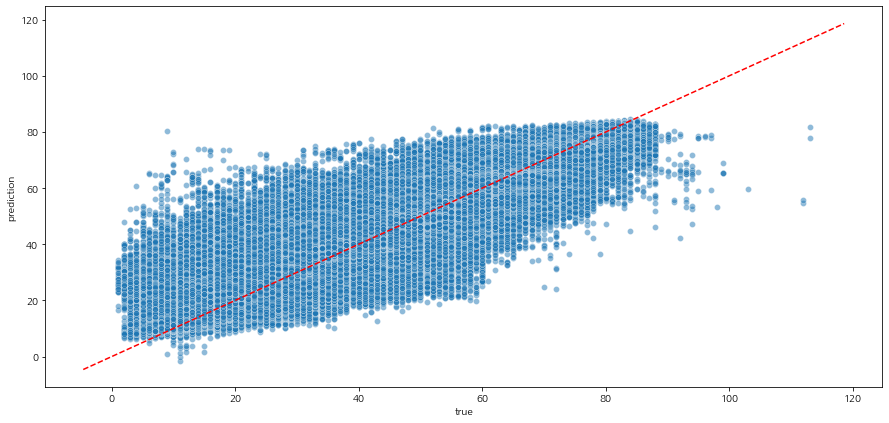

In [57]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [58]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [60]:
train_df7['pred_cat'] = train_fn['pred']
test_df7 ['pred_cat'] = test_fn ['pred']

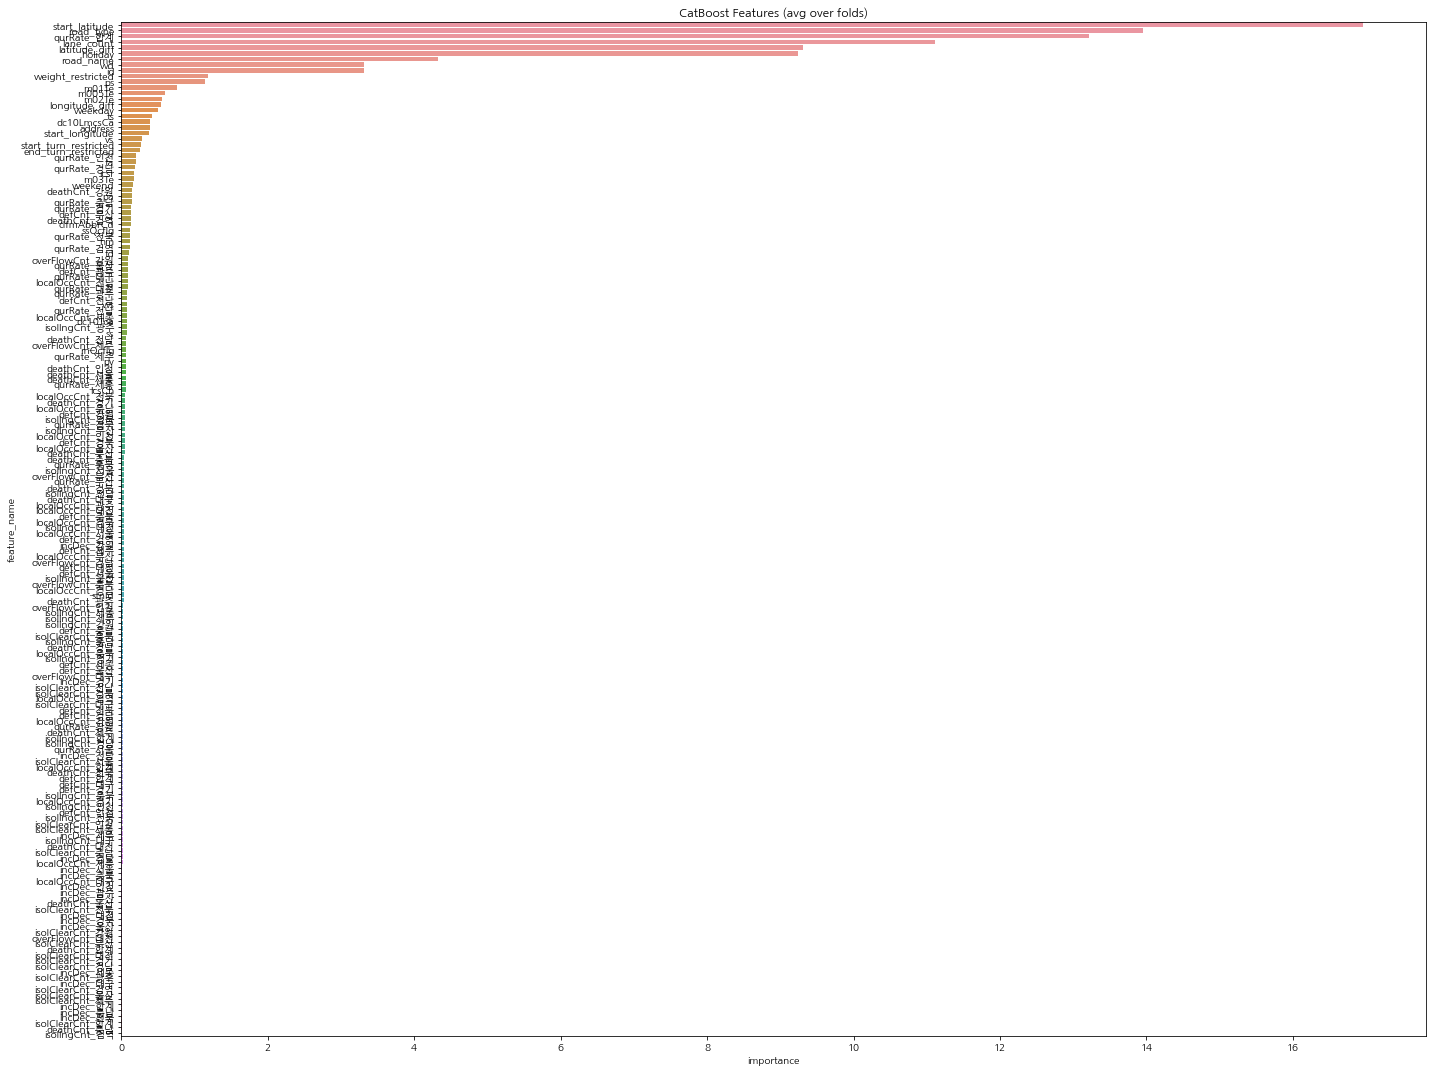

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp_df = pd.DataFrame(X_train.columns,columns=['feature_name'])

iter=0
for model in models:
    iter+=1
    
    feature_imp = pd.DataFrame(
        sorted(zip(X_train.columns,model.feature_importances_)), 
        columns=['feature_name','importance']
    )
    
    feature_imp[f'importance_{iter}'] = feature_imp['importance'] / feature_imp['importance'].sum()
    
    feature_imp_df = pd.merge(
        feature_imp_df,
        feature_imp[['feature_name',f'importance_{iter}']],
        how='left',
        on=['feature_name'],
    )

feature_imp_df = feature_imp_df.dropna()

imp_cols = [col for col in feature_imp_df.columns if col.find('importance_')>=0]
feature_imp_df['importance'] = feature_imp_df[imp_cols].apply(lambda x: sum(x),axis=1)
feature_imp_df['importance'] = 100 * feature_imp_df['importance'] / feature_imp_df['importance'].sum()
    
plt.figure(figsize=(20, 15))
sns.barplot(x="importance", y="feature_name", data=feature_imp_df.sort_values(by='importance', ascending=False))
plt.title('CatBoost Features (avg over folds)')
plt.tight_layout()
plt.show()

In [64]:
cat_check_df = feature_imp_df[['feature_name','importance']].sort_values('importance',ascending=False)
cat_check_df['cum_importance'] = cat_check_df['importance'].cumsum()

cutoff = 99
print(f'cumulative import ≥ {cutoff}% : {np.where(cat_check_df["cum_importance"]<=cutoff,1,0).sum()} / {cat_check_df.shape[0]}')
display(cat_check_df.head())

cumulative import ≥ 99% : 119 / 178


,feature_name,importance,cum_importance
5,start_latitude,16.962945,16.962945
4,road_type,13.958709,30.921655
177,qurRate_합계,13.211441,44.133096
1,lane_count,11.107641,55.240737
12,latitude_diff,9.311522,64.552259


In [66]:
train_df7.to_parquet('../OUT/train_fn.parquet.gz')
test_df7 .to_parquet('../OUT/test_fn.parquet.gz')

<br>

## CatBoost - Kfold (제외)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [ ]:
%%time

from catboost import CatBoostRegressor, Pool

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]

    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)
    # print('-'*100)
    # print(progress)
    # print('-'*100)
    
    models_kf = []
    for train_idx, valid_idx in kf.split(X_tr):
    
        X_tr_kf = X_tr.iloc[train_idx,:]
        X_va_kf = X_tr.iloc[valid_idx,:]
        y_tr_kf = y_tr.iloc[train_idx]
        y_va_kf = y_tr.iloc[valid_idx]
    
        train_data_kf = Pool(
            X_tr_kf.drop([segment_features,'id'],axis=1),
            y_tr_kf,
            cat_features=new_cat_features,
        )
        valid_data_kf = Pool(
            X_va_kf.drop([segment_features,'id'],axis=1),
            y_va_kf,
            cat_features=new_cat_features,
        )

        # iterations default=1,000
        model = CatBoostRegressor(
            loss_function = 'MAE',
            eval_metric = 'MAE',
            iterations=1000,
            early_stopping_rounds=30,
            verbose=0,
            random_state=42,
            # metric_period=500,
            #task_type='GPU',
        )
        model.fit(train_data_kf,eval_set=valid_data_kf,use_best_model=True)

        # save
        models_kf.append(model)
        #model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
        
    train_data = Pool(
        X_tr.drop([segment_features,'id'],axis=1),
        y_tr,
        cat_features=new_cat_features,
    )
    test_data = Pool(
        X_te.drop([segment_features,'id'],axis=1),
        cat_features=new_cat_features,
    )
    
    X_tr['pred'] = np.mean(np.array([model.predict(train_data) for model in models_kf]),axis=0)
    X_te['pred'] = np.mean(np.array([model.predict(test_data)  for model in models_kf]),axis=0)

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)

    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])
    
    mae = mean_absolute_error(y_true=y_tr,y_pred=X_tr['pred'])
    print(f'MAE : {mae:.4f}')

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
# submission = test_fn[['id','pred']].rename(columns={'pred':'target'}).sort_values('id')
# submission.to_csv(f'../OUT/submission_{now_date}.csv',index=False)

In [ ]:
train_df6['pred_cat_kf'] = train_fn['pred']
test_df6 ['pred_cat_kf'] = test_fn ['pred']

<br>

## LightGBM - Kfold (제외)

In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5)

In [ ]:
%%time

import lightgbm as lgb

params = {
    'task': 'train', 
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'num_iterations': 1000,
    'learning_rate': 0.05,
    'metric': 'MAE',
    'verbose': 0,
    'n_jobs': -1,
    'random_state': 0,
}

tr_segment = X_train[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

models = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1
    
    X_tr = X_train[X_train[segment_features]==segment_x]
    X_te = X_test [X_test [segment_features]==segment_x]

    y_tr = y_train[X_train[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train.shape[0]:,}({X_tr.shape[0]/X_train.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    X_tr[new_cat_features] = X_tr[new_cat_features].astype('category')
    X_te[new_cat_features] = X_te[new_cat_features].astype('category')
    
    models_kf = []
    # pbar2 = tqdm(kf.split(X_tr),total=5)
    for train_idx, valid_idx in kf.split(X_tr):
    
        X_tr_kf = X_tr.iloc[train_idx,:]
        X_va_kf = X_tr.iloc[valid_idx,:]
        y_tr_kf = y_tr.iloc[train_idx]
        y_va_kf = y_tr.iloc[valid_idx]

        # iterations default=1,000
        model = lgb.LGBMRegressor(**params)
        model.fit(
            X_tr_kf.drop([segment_features,'id'],axis=1),
            y_tr_kf,
            eval_set=[(
                X_va_kf.drop([segment_features,'id'],axis=1),
                y_va_kf
            )],
            eval_metric='MAE',
            early_stopping_rounds=50,
            verbose=-1,
        )

        # save
        models_kf.append(model)
        #model.save_model(f'../MDL/{now_date}/catboost_{segment_x}.cbm')
    
    X_tr['pred'] = np.mean(
        np.array([model.predict(X_tr.drop([segment_features,'id'],axis=1)) for model in models_kf]),
        axis=0
    )
    X_te['pred'] = np.mean(
        np.array([model.predict(X_te.drop([segment_features,'id'],axis=1)) for model in models_kf]),
        axis=0
    )

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)

    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])
    
    mae = mean_absolute_error(y_true=y_tr,y_pred=X_tr['pred'])
    print(f'MAE : {mae:.4f}')

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]
#     mae = mean_absolute_error(y_true=tmp['target'],y_pred=tmp['pred'])

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     plt.title(f'MAE : {mae:.4f}')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
submission = test_fn[['id','pred']].rename(columns={'pred':'target'}).sort_values('id')
submission.to_csv(f'../OUT/submission_{now_date}.csv',index=False)

In [ ]:
train_df6['pred_cat_kf'] = train_fn['pred']
test_df6 ['pred_cat_kf'] = test_fn ['pred']

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_lgb_kf_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_lgb_kf_{now_date}.parquet')

<br>

## Ensemble

In [ ]:
# train_df3 = pd.read_parquet(f'../OUT/train_df3_{now_date}.parquet')
# test_df3  = pd.read_parquet(f'../OUT/test_df3_{now_date}.parquet')

In [ ]:
pred_cols = ['pred_lgb','pred_cat']
train_df6['pred_ensemble'] = (train_df6['pred_lgb']+train_df6['pred_cat'])/2
test_df6 ['pred_ensemble'] = (test_df6 ['pred_lgb']+test_df6 ['pred_cat'])/2

# pred_cols = ['pred_lgb','pred_cat','pred_cat_kf']
# train_df5['pred_ensemble'] = (train_df5['pred_lgb']+train_df5['pred_cat']+train_df5['pred_cat_kf'])/3
# test_df5 ['pred_ensemble'] = (test_df5 ['pred_lgb']+test_df5 ['pred_cat']+test_df5 ['pred_cat_kf'])/3

In [ ]:
# ['pred_lr','pred_lgb','pred_cat','pred_cat_kf','pred_ensemble']
for col in ['pred_lgb','pred_cat','pred_ensemble']:
    tmp = train_df6[~train_df6['pred_ensemble'].isnull()]
    print(f'{col} MAE : {mean_absolute_error(y_true=tmp.target,y_pred=tmp[col]):.4f}')

In [ ]:
train_df6[[col for col in train_df6.columns if col.find('pred_')>=0]].corr()

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_{now_date}.parquet')

<br>

## Stacking

In [ ]:
from sklearn.linear_model import LinearRegression
meta_learner = LinearRegression()

In [ ]:
X_train = train_df6.drop(['target','base_date']+del_features+['pred_ensemble'],axis=1)
y_train = train_df6.target

X_test  = test_df6 .drop(['base_date']+del_features+['pred_ensemble'],axis=1)

In [ ]:
%%time

tmp = pd.concat([
    X_train.assign(group='train'),
    X_test .assign(group='test'),
],axis=0)

tmp = pd.get_dummies(tmp, columns=new_cat_features)

X_train_oh = tmp[tmp['group']=='train'].drop('group',axis=1)
X_test_oh  = tmp[tmp['group']=='test' ].drop('group',axis=1)

In [ ]:
# train에만 있는 segment length, test에만 있는 segment length 확인
tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

len(list(set(tr_segment)-set(te_segment))),len(list(set(te_segment)-set(tr_segment)))

In [ ]:
%%time

from sklearn.linear_model import LinearRegression
import pickle

tr_segment = X_train_oh[segment_features].value_counts().sort_values(ascending=False).index
te_segment = X_test_oh [segment_features].value_counts().index
segment    = [seg for seg in tr_segment if seg in te_segment]

# now_date = str(datetime.datetime.now()).replace(' ','').replace('-','').replace(':','').replace('.','')[:14]
now_date = str(datetime.datetime.now())
now_date = now_date[:now_date.find('.')]
# createFolder(f'../MDL/{now_date}/')
print(now_date)

meta_learners = []
train_fn = []
test_fn = []
iter = 0

pbar = tqdm(segment)
for segment_x in pbar:
    iter += 1

    X_tr = X_train_oh[X_train_oh[segment_features]==segment_x]
    X_te = X_test_oh [X_test_oh[segment_features]==segment_x]
    
    y_tr = y_train[X_train_oh[segment_features]==segment_x]
    y_tr = transformation(y_tr,offset=offset,method=transform_method)
    
    scalers = {}
    for col in new_num_features:
        scaler = scaling_method()
        scalers[col] = scaler
        
        X_tr[col] = scaler.fit_transform(np.array(X_tr[col]).reshape(-1,1))
        X_te[col] = scaler.transform(np.array(X_te[col]).reshape(-1,1))
    
    progress = f'{segment_x} : {X_tr.shape[0]:,}/{X_train_oh.shape[0]:,}({X_tr.shape[0]/X_train_oh.shape[0]*100:.2f}%)'
    pbar.set_description(progress)

    meta_learner.fit(X_tr.drop([segment_features,'id'],axis=1),y_tr)

    # save (https://stackoverflow.com/questions/64320741/linearregression-object-has-no-attribute-save)
    meta_learners.append(meta_learner)
    # pickle.dump(model, open(f'../MDL/{now_date}/lr_{segment_x}.sav', 'wb'))

    X_tr['pred'] = meta_learner.predict(X_tr.drop([segment_features,'id'],axis=1))
    X_te['pred'] = meta_learner.predict(X_te.drop([segment_features,'id'],axis=1))

    # inverse transformation
    X_tr['pred'] = inverse_transformation(X_tr['pred'],offset=offset,method=transform_method)
    X_te['pred'] = inverse_transformation(X_te['pred'],offset=offset,method=transform_method)
    
    y_tr = inverse_transformation(y_tr,offset=offset,method=transform_method)

    train_fn.append(pd.concat([X_tr[['id',segment_features,'pred']],y_tr],axis=1))
    test_fn .append(X_te[['id',segment_features,'pred']])

In [ ]:
train_fn = pd.concat(train_fn,axis=0)
test_fn  = pd.concat(test_fn ,axis=0)

In [ ]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_true=train_fn['target'],y_pred=train_fn['pred'])

In [ ]:
plt.figure(figsize=(15,7))
sns.scatterplot(train_fn['target'],train_fn['pred'],alpha=0.5)
plt.xlabel('true')
plt.ylabel('prediction')
abline(slope=1,intercept=0,color='red')
plt.show()

In [ ]:
# iter=0
# for seg in segment:
#     iter+=1
#     print(f'\n({iter}/{train_fn.segment.nunique()}) {seg}')
    
#     tmp = train_fn[train_fn.segment==seg]

#     plt.figure(figsize=(15,7))
#     sns.scatterplot(tmp['target'],tmp['pred'],alpha=0.5)
#     plt.xlabel('true')
#     plt.ylabel('prediction')
#     abline(slope=1,intercept=0,color='red')
#     plt.show()

In [ ]:
train_df6['pred_stacking'] = train_fn['pred']
test_df6 ['pred_stacking'] = test_fn ['pred']

In [ ]:
train_df6.to_parquet(f'../OUT/train_df6_{now_date}.parquet')
test_df6 .to_parquet(f'../OUT/test_df6_{now_date}.parquet')

In [ ]:
# ['pred_lr','pred_lgb','pred_cat','pred_cat_kf','pred_ensemble','pred_stacking']
for col in ['pred_lr','pred_lgb','pred_cat','pred_ensemble','pred_stacking']:
    tmp = train_df5[~train_df5['pred_lr'].isnull()]
    print(f'{col} MAE : {mean_absolute_error(y_true=tmp.target,y_pred=tmp[col]):.4f}')

In [ ]:
final_model = ['ensemble','stacking'][1]

submission = test_df6\
    [['id',f'pred_{final_model}']]\
    .rename(columns={f'pred_{final_model}':'target'})\
    .sort_values('id')
submission.to_csv(f'../OUT/submission_{now_date}_{final_model}.csv',index=False)

In [ ]:
submission.head()

<br></br>

In [ ]:
end_time = datetime.datetime.now()
run_time = end_time-start_time

print('='*45)
print(f'> start time : {start_time}')
print(f'>   end time : {end_time}')
print(f'>   run time : {run_time:}')
print('='*45)